In [1]:
import prose
import cabaret
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import image_generation
import bad_pixels

from astropy.io import fits
from prose import FitsManager, FITSImage, Sequence, blocks
from datetime import datetime, timedelta

callisto.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
io.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
ganymede.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
europa.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
artemis.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
trappist-south.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
trappist-north.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
saint-ex.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
liverpool.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
spirit.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)


/opt/anaconda3/envs/semester_project_2/lib/python3.11/site-packages/prose/console_utils.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Image Generation

Specifying all the parameters

In [2]:
# Parameters
ra  = 346.6263750   # in degrees
dec = -5.04346111   # in degrees
exposure_time = 10  # in seconds
base_date = datetime(2024, 1, 1, 0, 0, 0)
num_pixels_shift = 4
num_light_images = 50
num_dark_images = 5

camera_width  = 1024 
camera_height = 1024
camera_dark_current = 0.2
camera    = cabaret.Camera(width=camera_width, height=camera_height, dark_current=camera_dark_current)
telescope = cabaret.Telescope()

dir_base_images_light = 'images_light_guiding_warm_pixels'
dir_base_images_dark  = 'images_dark_guiding_warm_pixels'
dir_base_images_all   = 'images_all_guiding_warm_pixels'

Get the Seeing data from SPECULOOS

In [3]:
# Seeing data
json_file_path = '/Users/manishprasad/Documents/Semester_Project/pixel_defects/Io_Trappist-1.json'

with open(json_file_path, 'r') as file:
    seeing_file = json.load(file)

seeing_data = seeing_file['environment']['SEEING']

Generating light and dark images. Remove the comment if you want to actually generate images. The first line is for deleting existing files should you need it

In [4]:
image_generation.delete_files_in_folder(folder_path= dir_base_images_light)
image_generation.generate_light_images(ra, dec, exposure_time, base_date, num_pixels_shift, num_light_images, seeing_data, camera, telescope, dir_base_images_light)

Querying Gaia for sources...
"Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 10-12-2024 from 08:00 to 10:00 (CET)"
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Querying Gaia for sources...
Found 59 sources (user set limit of 2000).
Query

In [5]:
image_generation.delete_files_in_folder(folder_path= dir_base_images_dark)
image_generation.generate_dark_images(ra, dec, exposure_time, base_date, num_dark_images, num_light_images, seeing_data, camera, dir_base_images_dark)

Combining the lights and darks into a single folder for Prose and for adding bad pixels

In [6]:
image_generation.delete_files_in_folder(folder_path= dir_base_images_all)
image_generation.combine_folders(dir_base_images_light, dir_base_images_dark, dir_base_images_all = dir_base_images_all)

# Bad Pixels

Bad pixel parameters

In [7]:
percentage_hot =  0.306 # 5% of pixels to be set as 'hot'
percentage_cold = 0.271  # 5% of pixels to be set as 'hot'
hot_peak = 12000       # Mean value of hot pixels
hot_variance = 500    # Variance of the hot pixel values
hot_upper_limit = 12393

# Get one of the images to generate the bad pixels
fm = FitsManager('images_all_guiding_warm_pixels/', depth=1)
image = FITSImage(fm.all_images[0]).data  # 1024x1024 image filled with ones

Parsing FITS: 100%|██████████| 55/55 [00:00<00:00, 2376.43it/s]

INFO telescope  not found - using default


Adding hot and cold pixels onto the images

In [8]:
# Get the indices of the hot and cold pixels
hot_indices, dead_indices, hot_pixel_values, dead_pixel_values = bad_pixels.bad_pixel_locations(
    image, 
    percentage_hot, 
    percentage_cold, 
    hot_peak, 
    hot_variance,
    hot_upper_limit)

# Specify the directories for the raw images and the bad images
dir_raw_images = "./images_all_guiding_warm_pixels"
dir_bad_images = "./images_all_guiding_hot_cold_warm_pixels"

# Add the bad pixels to the images
image_generation.delete_files_in_folder(folder_path= 'images_all_guiding_hot_cold_warm_pixels/')
bad_pixels.add_bad_pixels(dir_raw_images, dir_bad_images, hot_indices, dead_indices, hot_pixel_values, dead_pixel_values)

Parsing FITS: 100%|██████████| 55/55 [00:00<00:00, 2276.86it/s]


INFO telescope  not found - using default
Light and dark images with bad pixels have been modified and saved in ./images_all_guiding_hot_cold_warm_pixels


Adding telegraphic pixels onto the images

In [9]:
telegraphic_percentage=0.1
interval=5

In [10]:
image_generation.delete_files_in_folder(folder_path= 'images_all_guiding_bad_pixels/')
bad_pixels.add_telegraphic_pixels(dir_bad_images, 'images_all_guiding_bad_pixels/', telegraphic_percentage=telegraphic_percentage, interval=interval)

Parsing FITS: 100%|██████████| 55/55 [00:00<00:00, 2015.68it/s]

INFO telescope  not found - using default


In [11]:
fm_bad_pixels = FitsManager("./images_all_guiding_bad_pixels", depth=1)

Parsing FITS: 100%|██████████| 55/55 [00:00<00:00, 2136.01it/s]

INFO telescope  not found - using default


Plotting the histograms of the images with and without bad pixels

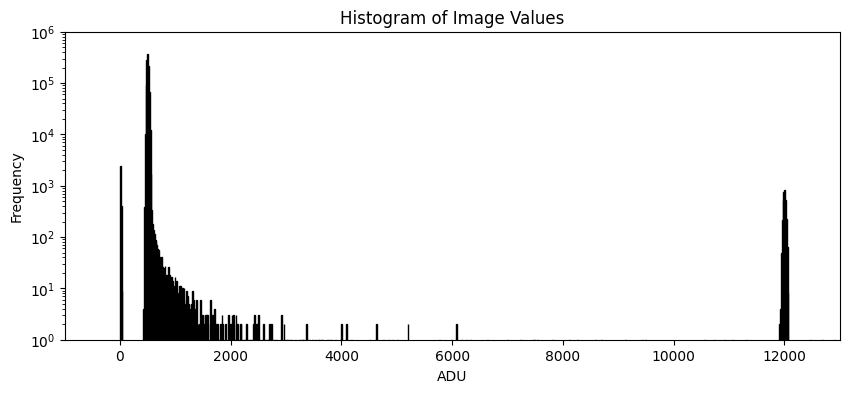

In [12]:
plt.figure(figsize=(10, 4))
plt.hist(FITSImage(fm_bad_pixels.all_images[0]).data.ravel(), bins=1000, color='gray', edgecolor='black')
plt.title("Histogram of Image Values")
plt.xlabel("ADU")
plt.ylabel("Frequency")
plt.xlim(-1000,13000)
plt.ylim(1, 1e6)  
plt.yscale('log')
plt.show()

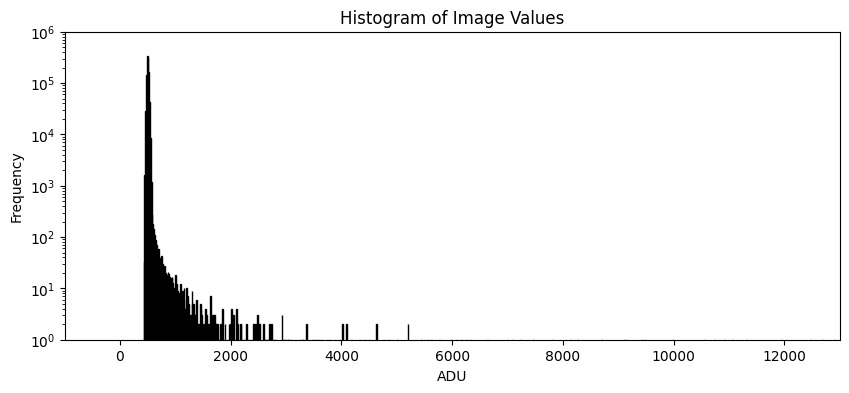

In [13]:
plt.figure(figsize=(10, 4))
plt.hist(FITSImage(fm.all_images[0]).data.ravel(), bins=1000, color='gray', edgecolor='black')
plt.title("Histogram of Image Values")
plt.xlabel("ADU")
plt.ylabel("Frequency")
plt.xlim(-1000,13000)
plt.ylim(1, 1e6)  
plt.yscale('log')
plt.show()

Image with bad pixels plotted using Prose

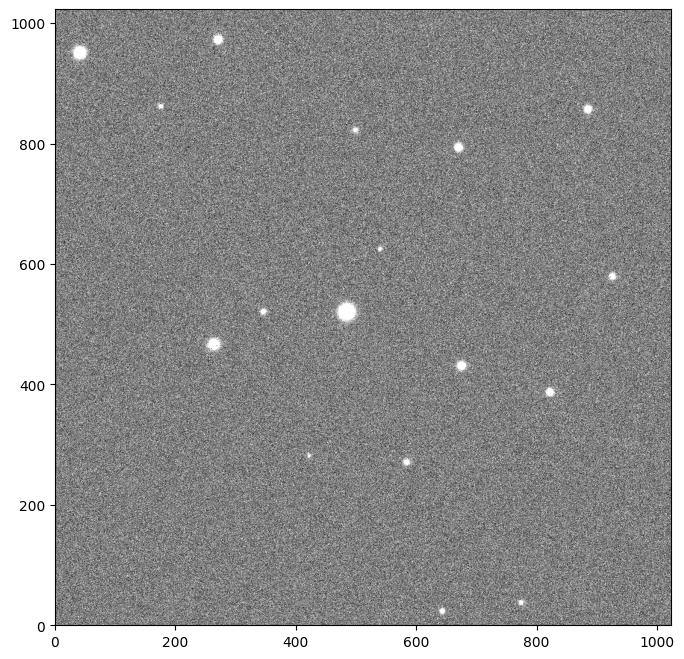

In [14]:
FITSImage(fm_bad_pixels.all_images[0]).show(contrast=0.5, cmap="gray")

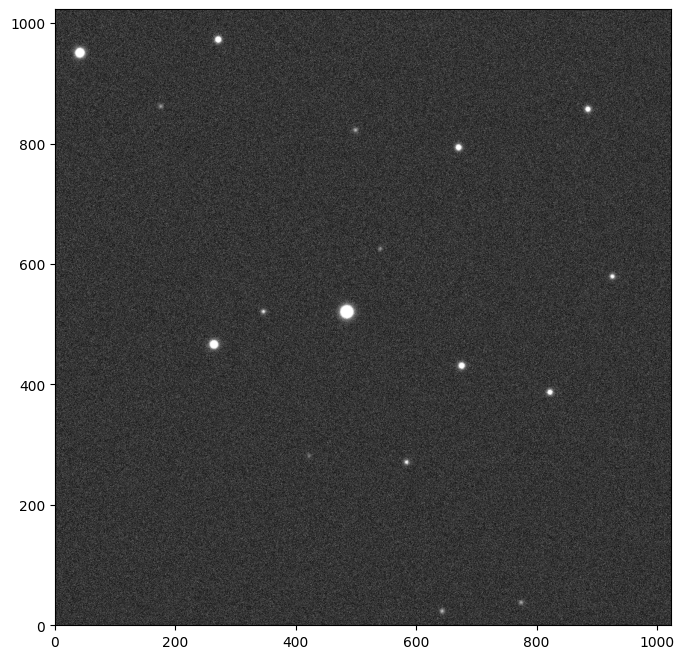

In [15]:
FITSImage(fm.all_images[0]).show()

In [16]:
fm.all_images

array(['/Users/manishprasad/Documents/Semester_Project/pixel_defects/images_all_guiding_warm_pixels/image_light_guiding_warm_pixels1.fits',
       '/Users/manishprasad/Documents/Semester_Project/pixel_defects/images_all_guiding_warm_pixels/image_light_guiding_warm_pixels2.fits',
       '/Users/manishprasad/Documents/Semester_Project/pixel_defects/images_all_guiding_warm_pixels/image_light_guiding_warm_pixels3.fits',
       '/Users/manishprasad/Documents/Semester_Project/pixel_defects/images_all_guiding_warm_pixels/image_light_guiding_warm_pixels4.fits',
       '/Users/manishprasad/Documents/Semester_Project/pixel_defects/images_all_guiding_warm_pixels/image_light_guiding_warm_pixels5.fits',
       '/Users/manishprasad/Documents/Semester_Project/pixel_defects/images_all_guiding_warm_pixels/image_light_guiding_warm_pixels6.fits',
       '/Users/manishprasad/Documents/Semester_Project/pixel_defects/images_all_guiding_warm_pixels/image_light_guiding_warm_pixels7.fits',
       '/Users/manis

# Plotting the light curve

array([PointSource(a=12.827960178036486, b=12.601203158965161, orientation=1.5855419546835607, coords=array([484.80026231, 520.30572704]), peak=14547.0, i=0, discarded=False),
       PointSource(a=9.416201997655552, b=9.283785369801711, orientation=0.8378531139375279, coords=array([ 41.41950987, 950.40635498]), peak=3826.0, i=1, discarded=False),
       PointSource(a=8.765071583921186, b=8.084368025224325, orientation=2.401814772586159, coords=array([263.99141885, 466.09244006]), peak=2599.0, i=2, discarded=False),
       PointSource(a=6.430885238863435, b=6.101283429657473, orientation=1.495734525030718, coords=array([271.04394841, 972.24222222]), peak=1025.0, i=3, discarded=False),
       PointSource(a=6.342134471797858, b=6.201387097666432, orientation=1.8731673824293036, coords=array([675.36006429, 430.69241547]), peak=996.0, i=4, discarded=False),
       PointSource(a=5.958657003707267, b=5.736773400398605, orientation=2.4728277690349354, coords=array([670.4112456 , 793.22910739])

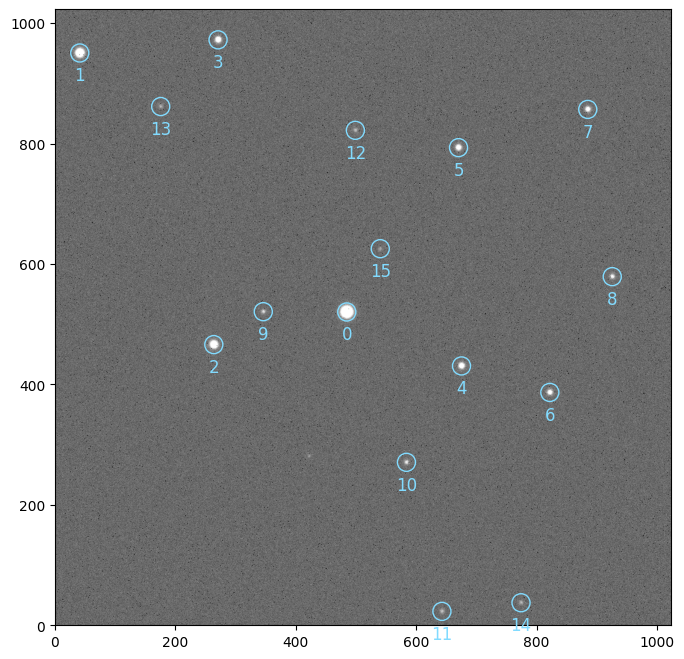

In [17]:
ref = FITSImage(fm_bad_pixels.all_images[0])
calibration = Sequence(
    [
        blocks.Calibration(darks=fm_bad_pixels.all_darks, bias=fm_bad_pixels.all_bias, flats=fm_bad_pixels.all_flats),
        blocks.Trim(),
        blocks.PointSourceDetection(min_area=5),#, minor_length=2, threshold=4),  # stars detection
        blocks.Cutouts(21),  # making stars cutouts
        blocks.MedianEPSF(),  # building PSF    
        blocks.psf.Moffat2D(),  # modeling PSF
    ]
)
 
calibration.run([ref], show_progress=False)

ref.show()
ref.sources

In [18]:
fm_bad_pixels

,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
2,2023-12-31,,,dark,,1024,1024,5
1,2023-12-31,,,light,,1024,1024,50


In [19]:
radii = np.linspace(0.2, 4, 30)

photometry = Sequence(
    [
        *calibration,  # calibration
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # local background estimate
        blocks.GetFluxes(),
    ]
)

photometry.run(fm_bad_pixels.all_images, loader=FITSImage)

100%|██████████| 50/50 [00:08<00:00,  5.64images/s]


### With bad pixels

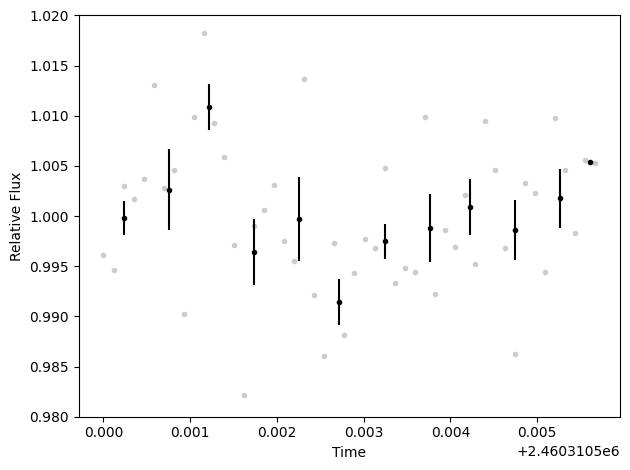

In [20]:
raw_fluxes = photometry[-1].fluxes

# picking target
raw_fluxes.target = 0

# good practice
raw_fluxes = raw_fluxes.sigma_clipping_data(bkg=3)

# differential photometry
diff_fluxes = raw_fluxes.autodiff()
diff_fluxes.plot()
diff_fluxes.bin(0.0005, True).errorbar()

plt.ylim(0.98, 1.02)
plt.xlabel("Time")
plt.ylabel("Relative Flux")
plt.tight_layout()

array([PointSource(a=12.84351861844275, b=12.585667672296035, orientation=1.504782100099932, coords=array([484.8061446 , 520.31320274]), peak=14547.0, i=0, discarded=False),
       PointSource(a=9.388755496170177, b=9.28453852879441, orientation=0.8224239182843217, coords=array([ 41.42741999, 950.37468584]), peak=3826.0, i=1, discarded=False),
       PointSource(a=8.773603778485146, b=8.069489479406805, orientation=2.416467821267454, coords=array([264.00881974, 466.08517047]), peak=2599.0, i=2, discarded=False),
       PointSource(a=6.430885238863435, b=6.101283429657473, orientation=1.495734525030718, coords=array([271.04394841, 972.24222222]), peak=1025.0, i=3, discarded=False),
       PointSource(a=6.342134471797858, b=6.201387097666432, orientation=1.8731673824293036, coords=array([675.36006429, 430.69241547]), peak=996.0, i=4, discarded=False),
       PointSource(a=5.958657003707267, b=5.736773400398605, orientation=2.4728277690349354, coords=array([670.4112456 , 793.22910739]), p

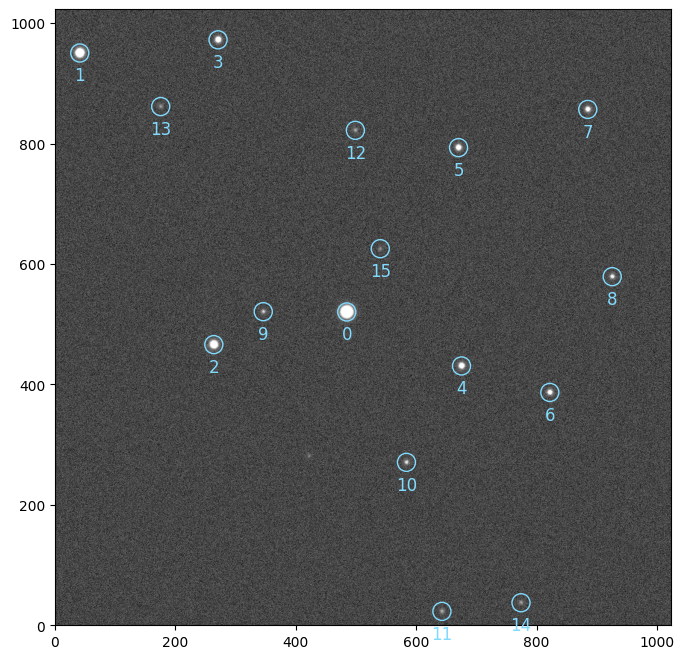

In [21]:
ref2 = FITSImage(fm.all_images[0])
calibration2 = Sequence(
    [
        blocks.Calibration(darks=fm.all_darks, bias=fm.all_bias, flats=fm.all_flats),
        blocks.Trim(),
        blocks.PointSourceDetection(min_area=5),#, minor_length=2, threshold=4),  # stars detection
        blocks.Cutouts(21),  # making stars cutouts
        blocks.MedianEPSF(),  # building PSF    
        blocks.psf.Moffat2D(),  # modeling PSF
    ]
)
 
calibration2.run([ref2], show_progress=False)

ref2.show()
ref2.sources

In [22]:
radii = np.linspace(0.2, 4, 30)

photometry2 = Sequence(
    [
        *calibration2,  # calibration
        blocks.ComputeTransformTwirl(ref2),  # compute alignment
        blocks.AlignReferenceSources(ref2),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # local background estimate
        blocks.GetFluxes(),
    ]
)

photometry2.run(fm.all_images, loader=FITSImage)

100%|██████████| 50/50 [00:09<00:00,  5.42images/s]


In [23]:
fm

,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
2,2023-12-31,,,dark,,1024,1024,5
1,2023-12-31,,,light,,1024,1024,50


### Without bad pixels

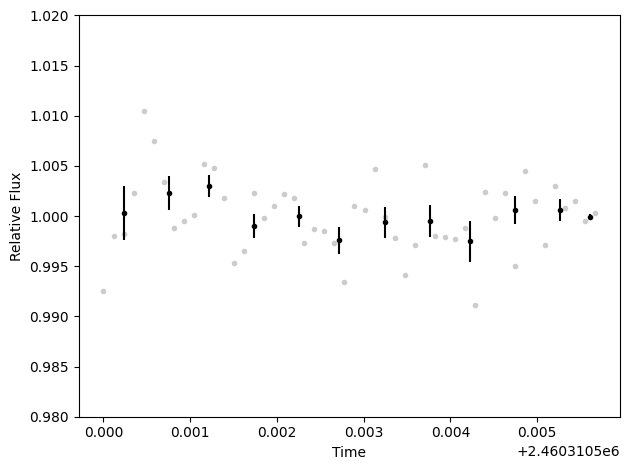

In [24]:
raw_fluxes2 = photometry2[-1].fluxes

# picking target
raw_fluxes2.target = 0
    

# good practice
raw_fluxes2 = raw_fluxes2.sigma_clipping_data(bkg=3)

# differential photometry
diff_fluxes2 = raw_fluxes2.autodiff()
diff_fluxes2.plot()
diff_fluxes2.bin(0.0005, True).errorbar()

plt.ylim(0.98, 1.02)
plt.xlabel("Time")
plt.ylabel("Relative Flux")
plt.tight_layout()